### Preprocessing

In [1]:
import pandas as pd

df = pd.read_csv("agri_CO2_preprocessing_ex.csv")
print(df.columns)

Index(['Area', 'Year', 'Savanna fires', 'Forest fires', 'Crop Residues',
       'Rice Cultivation', 'Drained organic soils (CO2)',
       'Pesticides Manufacturing', 'Food Transport', 'Forestland',
       'Net Forest conversion', 'Food Household Consumption', 'Food Retail',
       'On-farm Electricity Use', 'Food Packaging',
       'Agrifood Systems Waste Disposal', 'Food Processing',
       'Fertilizers Manufacturing', 'IPPU', 'Manure applied to Soils',
       'Manure left on Pasture', 'Manure Management', 'Fires in organic soils',
       'Fires in humid tropical forests', 'On-farm energy use',
       'Rural population', 'Urban population', 'Total Population - Male',
       'Total Population - Female', 'total_emission',
       'Average Temperature °C'],
      dtype='object')


In [2]:
emission_cols = [
    'Savanna fires', 'Forest fires', 'Crop Residues', 'Rice Cultivation',
    'Drained organic soils (CO2)', 'Pesticides Manufacturing', 'Food Transport',
    'Forestland', 'Net Forest conversion', 'Food Household Consumption',
    'Food Retail', 'On-farm Electricity Use', 'Food Packaging',
    'Agrifood Systems Waste Disposal', 'Food Processing', 'Fertilizers Manufacturing',
    'IPPU', 'Manure applied to Soils', 'Manure left on Pasture', 'Manure Management',
    'Fires in organic soils', 'Fires in humid tropical forests',
    'On-farm energy use'
]

In [3]:
# Dictionary of global annual temperature change
yearly_avg_temp = {
    1990: 0.18, 1991: -0.04, 1992: -0.19, 1993: 0.01, 1994: 0.08, 
    1995: 0.13, 1996: -0.11, 1997: 0.13, 1998: 0.15, 1999: -0.23, 
    2000: 0.01, 2001: 0.14, 2002: 0.10, 2003: -0.01, 2004: -0.09, 
    2005: 0.15, 2006: -0.04, 2007: 0.02, 2008: -0.12, 2009: 0.12, 
    2010: 0.07, 2011: -0.12, 2012: 0.04, 2013: 0.03, 2014: 0.07, 
    2015: 0.15, 2016: 0.11, 2017: -0.09, 2018: -0.07, 2019: 0.13, 
    2020: 0.03

}

# Map the temperature to the dataframe by Year
df['Yearly_Avg_Temp'] = df['Year'].map(yearly_avg_temp)

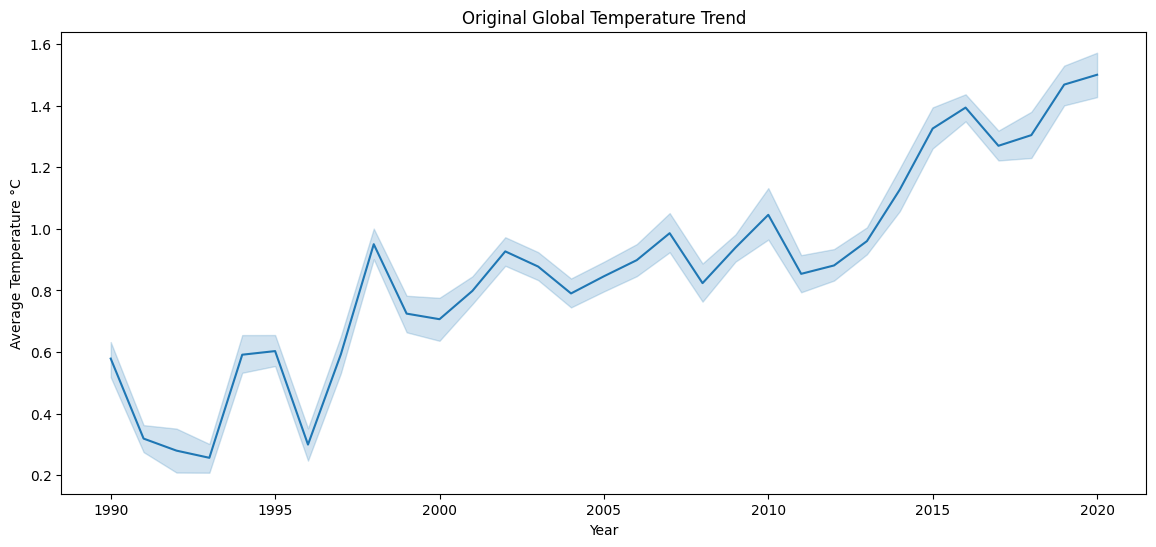

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

sns.lineplot(data=df, x='Year', y='Average Temperature °C')
plt.title('Original Global Temperature Trend')
plt.savefig("global_temp.png")

In [5]:
df['Detrended_Temp'] = df['Average Temperature °C'] - df['Yearly_Avg_Temp']

Tried linear regression but data is not normally distributed + residuals are not constant

In [6]:
import numpy as np

# Add binary label: 1 if Detrended_Temp >= 0, else 0
df['temp_label'] = np.where(df['Detrended_Temp'] >= 0, 1, 0)
print("Label occurences:\n", df["temp_label"].value_counts())

Label occurences:
 temp_label
1    6624
0     310
Name: count, dtype: int64


In [7]:
# 1. Drop near-constant columns
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=0.01)  # tune threshold
reduced_df = df[emission_cols]
filtered = vt.fit_transform(reduced_df)

# Get column names that survived
selected_cols = [col for col, keep in zip(reduced_df.columns, vt.get_support()) if keep]
# None dropped

In [8]:
from sklearn.feature_selection import f_regression

# Step 1: Correlation matrix (absolute values)
corr_matrix = df[selected_cols].corr().abs()

# Step 2: Upper triangle mask (excluding diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3: Calculate p-values for all features
X = df[selected_cols]
y = df['Detrended_Temp']
f_vals, p_vals = f_regression(X, y)

# Create a dictionary mapping feature -> p-value
pval_dict = dict(zip(X.columns, p_vals))

# Step 4: Identify correlated pairs and drop the one with higher p-value
to_drop = set()
for col in upper_tri.columns:
    for row in upper_tri.index:
        if row != col and upper_tri.loc[row, col] > 0.9:
            p1 = pval_dict.get(row, 1.0)
            p2 = pval_dict.get(col, 1.0)
            if p1 > p2:
                to_drop.add(row)
            else:
                to_drop.add(col)

# Step 5: Filter columns
filtered_cols = [col for col in selected_cols if col not in to_drop]

print("Dropped due to correlation & p-value comparison:", to_drop)
print("Remaining features:", filtered_cols)

Dropped due to correlation & p-value comparison: {'Food Packaging', 'Fertilizers Manufacturing', 'Fires in humid tropical forests', 'Food Household Consumption', 'Food Processing', 'Manure Management', 'Agrifood Systems Waste Disposal', 'Crop Residues', 'On-farm energy use'}
Remaining features: ['Savanna fires', 'Forest fires', 'Rice Cultivation', 'Drained organic soils (CO2)', 'Pesticides Manufacturing', 'Food Transport', 'Forestland', 'Net Forest conversion', 'Food Retail', 'On-farm Electricity Use', 'IPPU', 'Manure applied to Soils', 'Manure left on Pasture', 'Fires in organic soils']


In [9]:
X = df[filtered_cols]
y = df['temp_label']

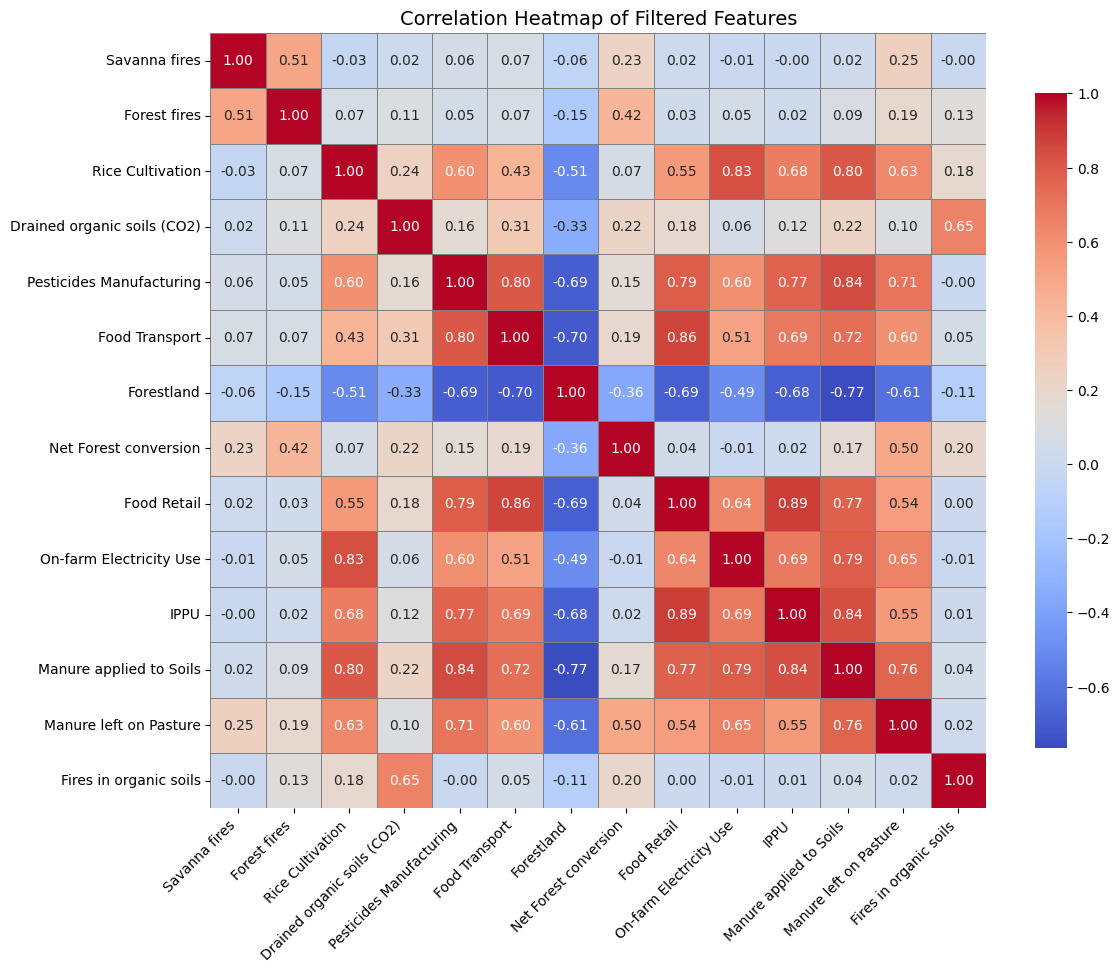

In [10]:
# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    df[filtered_cols].corr(), 
    annot=True, fmt=".2f", cmap="coolwarm", 
    square=True, cbar_kws={'shrink': .8},
    linewidths=0.5, linecolor='gray'
)
plt.title("Correlation Heatmap of Filtered Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("corr.png")
plt.show()

### Run Models with Different Sampling Methods

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    balanced_accuracy_score, classification_report, confusion_matrix,
    precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define classifiers
models = {
    'KNN': KNeighborsClassifier(),
    'LogReg': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'XGBoost' : xgb.XGBClassifier(tree_method="hist")
}

# Sampling strategies
sampling_strategies = {
    'SMOTE': SMOTE(random_state=42),
    'Tomek': TomekLinks(),
    'SMOTE+Tomek': SMOTETomek(random_state=42),
    'RandomUnder': RandomUnderSampler(random_state=42),
    'CostSensitive': None  # No sampler, use class_weight
}

# Store results
results = []

# Run traditional models
for samp_name, sampler in sampling_strategies.items():
    for model_name, model in models.items():
        if samp_name == 'CostSensitive':
            if hasattr(model, 'class_weight'):
                model.set_params(class_weight='balanced')
            clf = Pipeline([('scaler', StandardScaler()), ('model', model)])
        else:
            model.set_params(**{'class_weight': None} if hasattr(model, 'class_weight') else {})
            clf = ImbPipeline([('sampler', sampler), ('scaler', StandardScaler()), ('model', model)])

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        results.append({
            'Sampling': samp_name,
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Recall' : recall_score(y_test, y_pred),
            'Recall (class 1)': recall_score(y_test, y_pred, pos_label=1),
            'Recall (class 0)': recall_score(y_test, y_pred, pos_label=0),
            'Precision (class 1)': precision_score(y_test, y_pred, pos_label=1),
            'Precision (class 0)': precision_score(y_test, y_pred, pos_label=0),
            'F1 Score (macro)': f1_score(y_test, y_pred, average='macro'),
            'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred)
        })

# ==== RNN (separately handled) ====
# Scale and reshape input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y, stratify=y, test_size=0.2, random_state=42)

# Define RNN model
rnn_model = Sequential([
    SimpleRNN(32, activation='relu', input_shape=(1, X.shape[1])),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train RNN
rnn_model.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=16, validation_split=0.2, verbose=0)

# Evaluate
y_pred_prob_rnn = rnn_model.predict(X_test_rnn)
y_pred_rnn = (y_pred_prob_rnn > 0.5).astype(int)

results.append({
    'Sampling': 'None',
    'Model': 'RNN',
    'Accuracy': accuracy_score(y_test_rnn, y_pred_rnn),
    'Recall' : recall_score(y_test_rnn, y_pred_rnn),
    'Recall (class 1)': recall_score(y_test_rnn, y_pred_rnn, pos_label=1),
    'Recall (class 0)': recall_score(y_test_rnn, y_pred_rnn, pos_label=0),
    'Precision (class 1)': precision_score(y_test_rnn, y_pred_rnn, pos_label=1),
    'Precision (class 0)': precision_score(y_test_rnn, y_pred_rnn, pos_label=0),
    'F1 Score (macro)': f1_score(y_test_rnn, y_pred_rnn, average='macro'),
    'Balanced Accuracy': balanced_accuracy_score(y_test_rnn, y_pred_rnn)
})

# Show results
result_df = pd.DataFrame(results)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Run RNN Model with Sampling Methods

In [16]:
rnn_results = []
rnn_sampling_strategies = {
    'SMOTE': SMOTE(random_state=42),
    'Tomek': TomekLinks(),
    'SMOTE+Tomek': SMOTETomek(random_state=42),
    'RandomUnder': RandomUnderSampler(random_state=42)
}

for name, sampler in rnn_sampling_strategies.items():
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply sampler
    X_resampled, y_resampled = sampler.fit_resample(X_scaled, y)

    # Reshape for RNN: (samples, timesteps, features)
    X_rnn = X_resampled.reshape((X_resampled.shape[0], 1, X_resampled.shape[1]))

    # Split
    X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_resampled, stratify=y_resampled, test_size=0.2, random_state=42)

    # RNN Model
    model = Sequential([
        SimpleRNN(32, activation='relu', input_shape=(1, X.shape[1])),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train_rnn, y_train_rnn, epochs=20, batch_size=16, verbose=0, validation_split=0.2)

    y_pred_rnn = (model.predict(X_test_rnn) > 0.5).astype(int)

    rnn_results.append({
        'Sampling': name,
        'Model': 'RNN',
        'Accuracy': accuracy_score(y_test_rnn, y_pred_rnn),
        'Recall' : recall_score(y_test_rnn, y_pred_rnn),
        'Recall (class 1)': recall_score(y_test_rnn, y_pred_rnn, pos_label=1),
        'Recall (class 0)': recall_score(y_test_rnn, y_pred_rnn, pos_label=0),
        'Precision (class 1)': precision_score(y_test_rnn, y_pred_rnn, pos_label=1),
        'Precision (class 0)': precision_score(y_test_rnn, y_pred_rnn, pos_label=0),
        'F1 Score (macro)': f1_score(y_test_rnn, y_pred_rnn, average='macro'),
        'Balanced Accuracy': balanced_accuracy_score(y_test_rnn, y_pred_rnn)
    })

# Combine with previous results
result_df = pd.concat([pd.DataFrame(results), pd.DataFrame(rnn_results)], ignore_index=True)
print(result_df.sort_values(by='F1 Score (macro)', ascending=False))

C:\Users\JYC\System\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\JYC\System\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


C:\Users\JYC\System\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JYC\System\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


C:\Users\JYC\System\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
         Sampling         Model  Accuracy    Recall  Recall (class 1)  \
26          SMOTE           RNN  0.736226  0.714717          0.714717   
28    SMOTE+Tomek           RNN  0.726304  0.552171          0.552171   
10    SMOTE+Tomek           KNN  0.894737  0.916226          0.916226   
0           SMOTE           KNN  0.897621  0.920000          0.920000   
2           SMOTE  RandomForest  0.926460  0.957736          0.957736   
12    SMOTE+Tomek  RandomForest  0.923576  0.954717          0.954717   
4           SMOTE       XGBoost  0.921413  0.952453          0.952453   
14    SMOTE+Tomek       XGBoost  0.918529  0.949434          0.949434   
5           Tomek           KNN  0.953857  0.993208          0.993208   
23  CostSensitive  DecisionTree  0.932228  0.968302          0.968302   
3           SMOTE  DecisionTree  0.902668  0.932830          0.932830   
8           Tomek  DecisionTree  0.925739  0.960755          0.960755   
9           T

In [17]:
result_df

,Sampling,Model,Accuracy,Recall,Recall (class 1),Recall (class 0),Precision (class 1),Precision (class 0),F1 Score (macro),Balanced Accuracy
0,SMOTE,KNN,0.897621,0.920000,0.920000,0.419355,0.971315,0.196970,0.606501,0.669677
1,SMOTE,LogReg,0.392213,0.377358,0.377358,0.709677,0.965251,0.050633,0.318558,0.543518
2,SMOTE,RandomForest,0.926460,0.957736,0.957736,0.258065,0.965019,0.222222,0.600085,0.607900
3,SMOTE,DecisionTree,0.902668,0.932830,0.932830,0.258065,0.964119,0.152381,0.569917,0.595447
4,SMOTE,XGBoost,0.921413,0.952453,0.952453,0.258065,0.964832,0.202532,0.592776,0.605259
5,Tomek,KNN,0.953857,0.993208,0.993208,0.112903,0.959883,0.437500,0.577874,0.553055
6,Tomek,LogReg,0.955299,1.000000,1.000000,0.000000,0.955299,0.000000,0.488569,0.500000
7,Tomek,RandomForest,0.945926,0.985660,0.985660,0.096774,0.958884,0.240000,0.555009,0.541217
8,Tomek,DecisionTree,0.925739,0.960755,0.960755,0.177419,0.961480,0.174603,0.568559,0.569087
9,Tomek,XGBoost,0.940880,0.978868,0.978868,0.129032,0.960030,0.222222,0.566311,0.553950


### Re-run Best Model: RNN + SMOTE

In [14]:
rnn_results = []
rnn_sampling_strategies = {
    'SMOTE': SMOTE(random_state=42),
}

for name, sampler in rnn_sampling_strategies.items():
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply sampler
    X_resampled, y_resampled = sampler.fit_resample(X_scaled, y)

    # Reshape for RNN: (samples, timesteps, features)
    X_rnn = X_resampled.reshape((X_resampled.shape[0], 1, X_resampled.shape[1]))

    # Split
    X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_resampled, stratify=y_resampled, test_size=0.2, random_state=42)

    # RNN Model
    rnn_model = Sequential([
        SimpleRNN(32, activation='relu', input_shape=(1, X.shape[1])),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    rnn_model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train RNN with EarlyStopping
history = rnn_model.fit(
    X_train_rnn, y_train_rnn, 
    epochs=100, 
    batch_size=16, 
    validation_split=0.2, 
    verbose=0,
    callbacks=[early_stopping]
)

import joblib
rnn_model.save("rnn_model_smote.h5")
joblib.dump(scaler, "rnn_scaler_smote.pkl")

y_pred_rnn = (rnn_model.predict(X_test_rnn) > 0.5).astype(int)

print({
    'Sampling': name,
    'Model': 'RNN',
    'Accuracy': accuracy_score(y_test_rnn, y_pred_rnn),
    'Recall' : recall_score(y_test_rnn, y_pred_rnn),
    'Recall (class 1)': recall_score(y_test_rnn, y_pred_rnn, pos_label=1),
    'Recall (class 0)': recall_score(y_test_rnn, y_pred_rnn, pos_label=0),
    'Precision (class 1)': precision_score(y_test_rnn, y_pred_rnn, pos_label=1),
    'Precision (class 0)': precision_score(y_test_rnn, y_pred_rnn, pos_label=0),
    'F1 Score (macro)': f1_score(y_test_rnn, y_pred_rnn, average='macro'),
    'Balanced Accuracy': balanced_accuracy_score(y_test_rnn, y_pred_rnn)
})

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
{'Sampling': 'SMOTE', 'Model': 'RNN', 'Accuracy': 0.7264150943396226, 'Recall': 0.6490566037735849, 'Recall (class 1)': 0.6490566037735849, 'Recall (class 0)': 0.8037735849056604, 'Precision (class 1)': 0.7678571428571429, 'Precision (class 0)': 0.696078431372549, 'F1 Score (macro)': 0.7247680136380403, 'Balanced Accuracy': 0.7264150943396226}


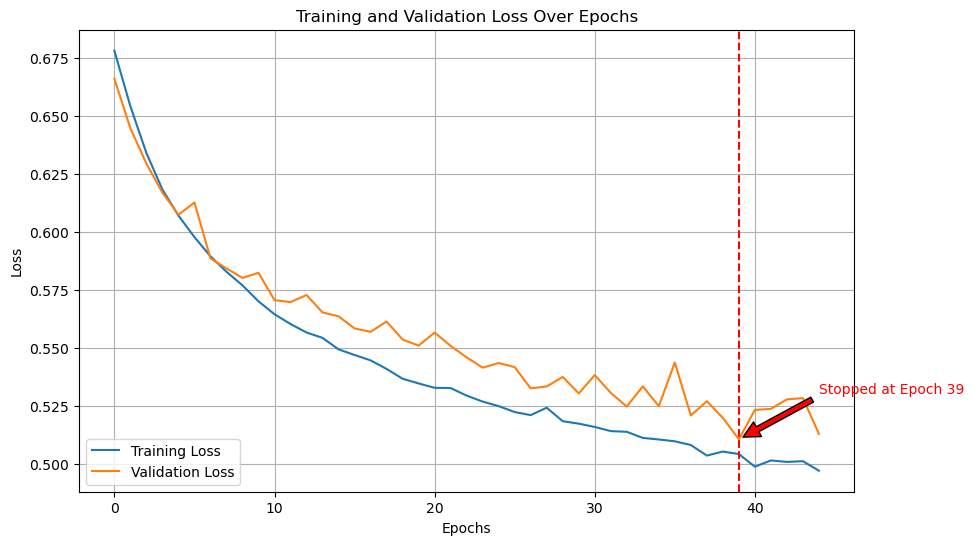

In [22]:
# Find the best epoch (the one with the minimum validation loss)
best_epoch = np.argmin(history.history['val_loss'])

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Annotate the early stopping point
plt.axvline(best_epoch, color='red', linestyle='--')
plt.annotate(f'Stopped at Epoch {best_epoch}', 
             xy=(best_epoch, history.history['val_loss'][best_epoch]), 
             xytext=(best_epoch + 5, history.history['val_loss'][best_epoch] + 0.02),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=10, color='red')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.savefig("epoch.png")
plt.show()

Confusion Matrix:
[[1019  306]
 [ 394  931]]


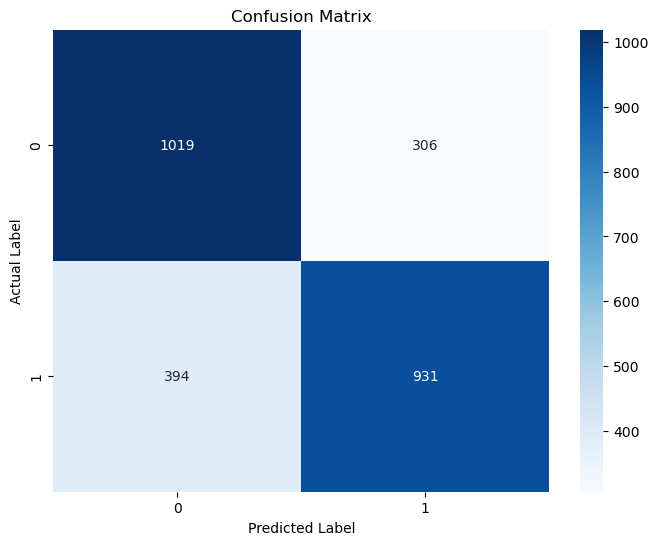

In [23]:
# Get confusion matrix
cm = confusion_matrix(y_test_rnn, y_pred_rnn)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig("confusion.png")
plt.show()

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test_rnn, y_pred_rnn))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      1325
           1       0.75      0.70      0.73      1325

    accuracy                           0.74      2650
   macro avg       0.74      0.74      0.74      2650
weighted avg       0.74      0.74      0.74      2650



### Permutation to Find Top Influential Features

In [26]:
def calculate_macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

# Baseline macro F1 score
y_pred_baseline = (rnn_model.predict(X_test_rnn) > 0.5).astype(int)
baseline_f1 = calculate_macro_f1(y_test_rnn, y_pred_baseline)

importances = []
for i in range(X_test_rnn.shape[2]):  # loop over features
    X_permuted = X_test_rnn.copy()
    np.random.shuffle(X_permuted[:, 0, i])  # shuffle feature i across all samples

    y_pred = (rnn_model.predict(X_permuted) > 0.5).astype(int)
    f1 = calculate_macro_f1(y_test_rnn, y_pred)

    importances.append(baseline_f1 - f1)

# Map back to feature names
feature_importance = dict(zip(filtered_cols, importances))
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print top features
for feat, score in sorted_importance:
    print(f"{feat}: {score:.4f}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
On-farm Electricity Use: 0.1126
Manure left on Pasture: 0.0850
Food Retail: 0.0651
Net Forest conversion: 0.0587
Food Transport: 0.0574
Forestland: 0.0557
Savanna fires: 0.0528
Drained organic soils (CO2): 0.0433
IPPU: 0.0429
Manure applied to Soils: 0.0428
Pesticides Manufacturing: 0.0408
Rice Cultivation: 0.0339
Forest fires: 0.0243
Fires in organic soils: -0.0004


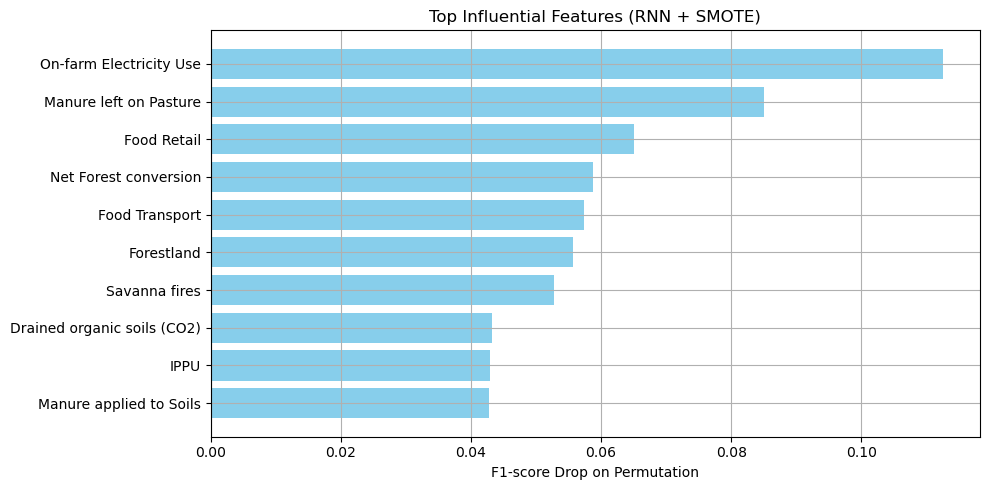

In [27]:
top_feats = sorted_importance[:10]
labels, scores = zip(*top_feats)

plt.figure(figsize=(10, 5))
plt.barh(labels[::-1], scores[::-1], color='skyblue')
plt.title("Top Influential Features (RNN + SMOTE)")
plt.xlabel("F1-score Drop on Permutation")
plt.grid(True)
plt.tight_layout()
plt.savefig("influential_feat.png")
plt.show()

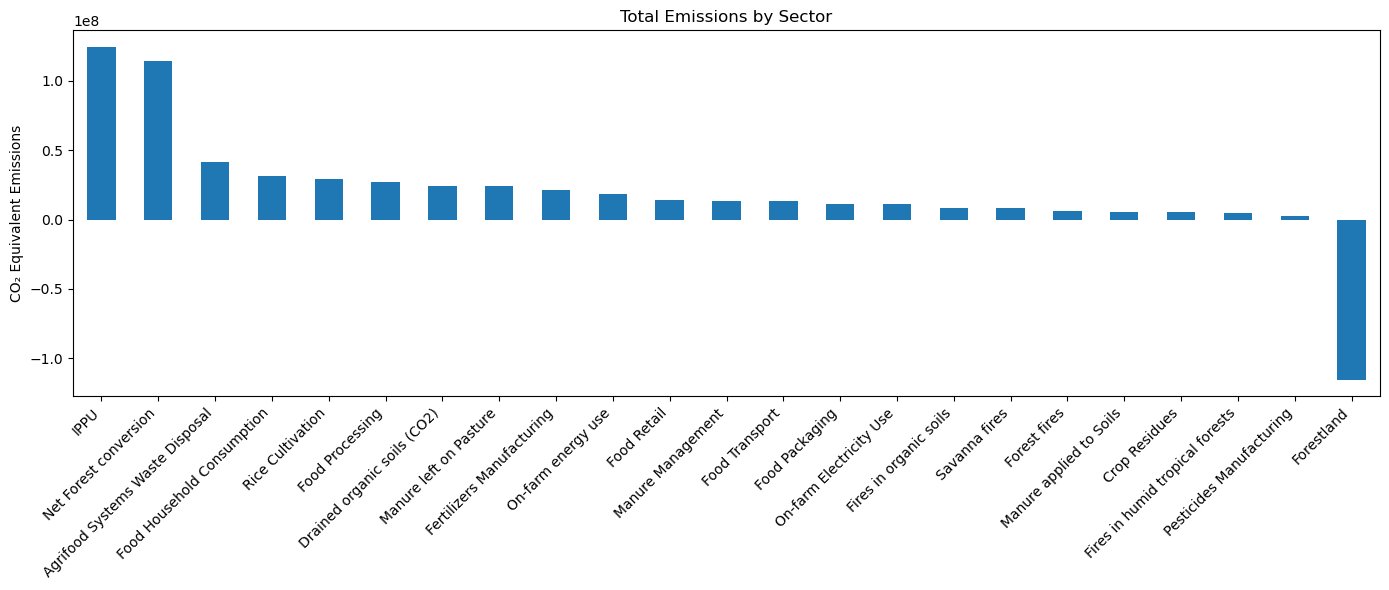

In [28]:
sector_totals = df[emission_cols].sum().sort_values(ascending=False)

sector_totals.plot(kind='bar', figsize=(14, 6), title="Total Emissions by Sector")
plt.ylabel("CO₂ Equivalent Emissions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

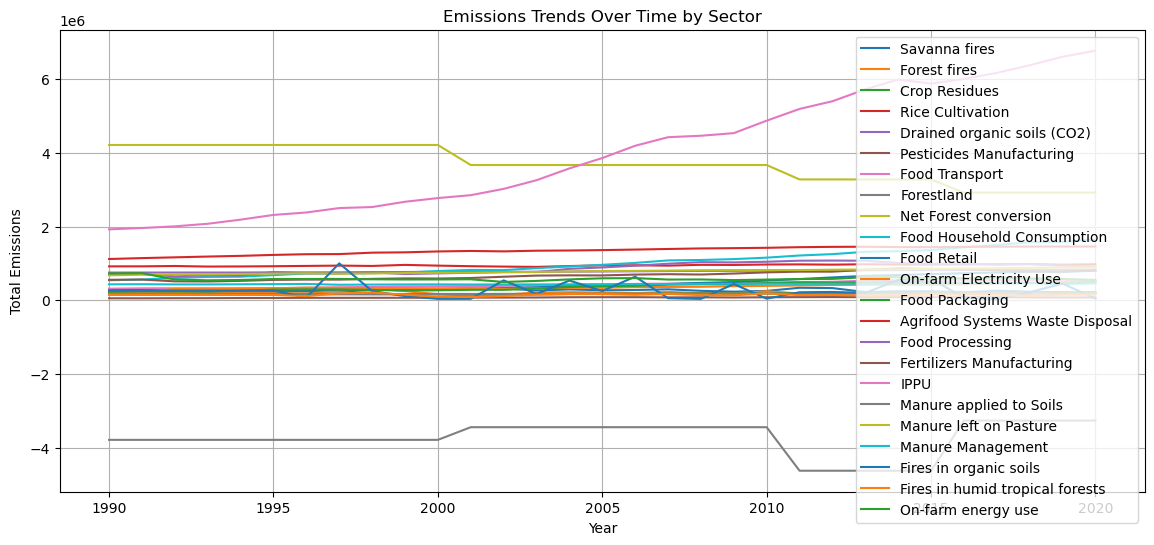

In [29]:
emissions_over_time = df.groupby("Year")[emission_cols].sum()
plt.figure(figsize=(14, 6))
for col in emission_cols:
    plt.plot(emissions_over_time.index, emissions_over_time[col], label=col)

plt.title("Emissions Trends Over Time by Sector")
plt.xlabel("Year")
plt.ylabel("Total Emissions")
plt.legend()
plt.grid(True)
plt.show()